--- Training XGBoost model on pre-promotion period ---
--- Predicting the counterfactual scenario ---

--- Causal Impact Analysis Results ---
Total Causal Impact: $155,657.73 in additional sales.
Relative Causal Impact: 0.19% uplift.


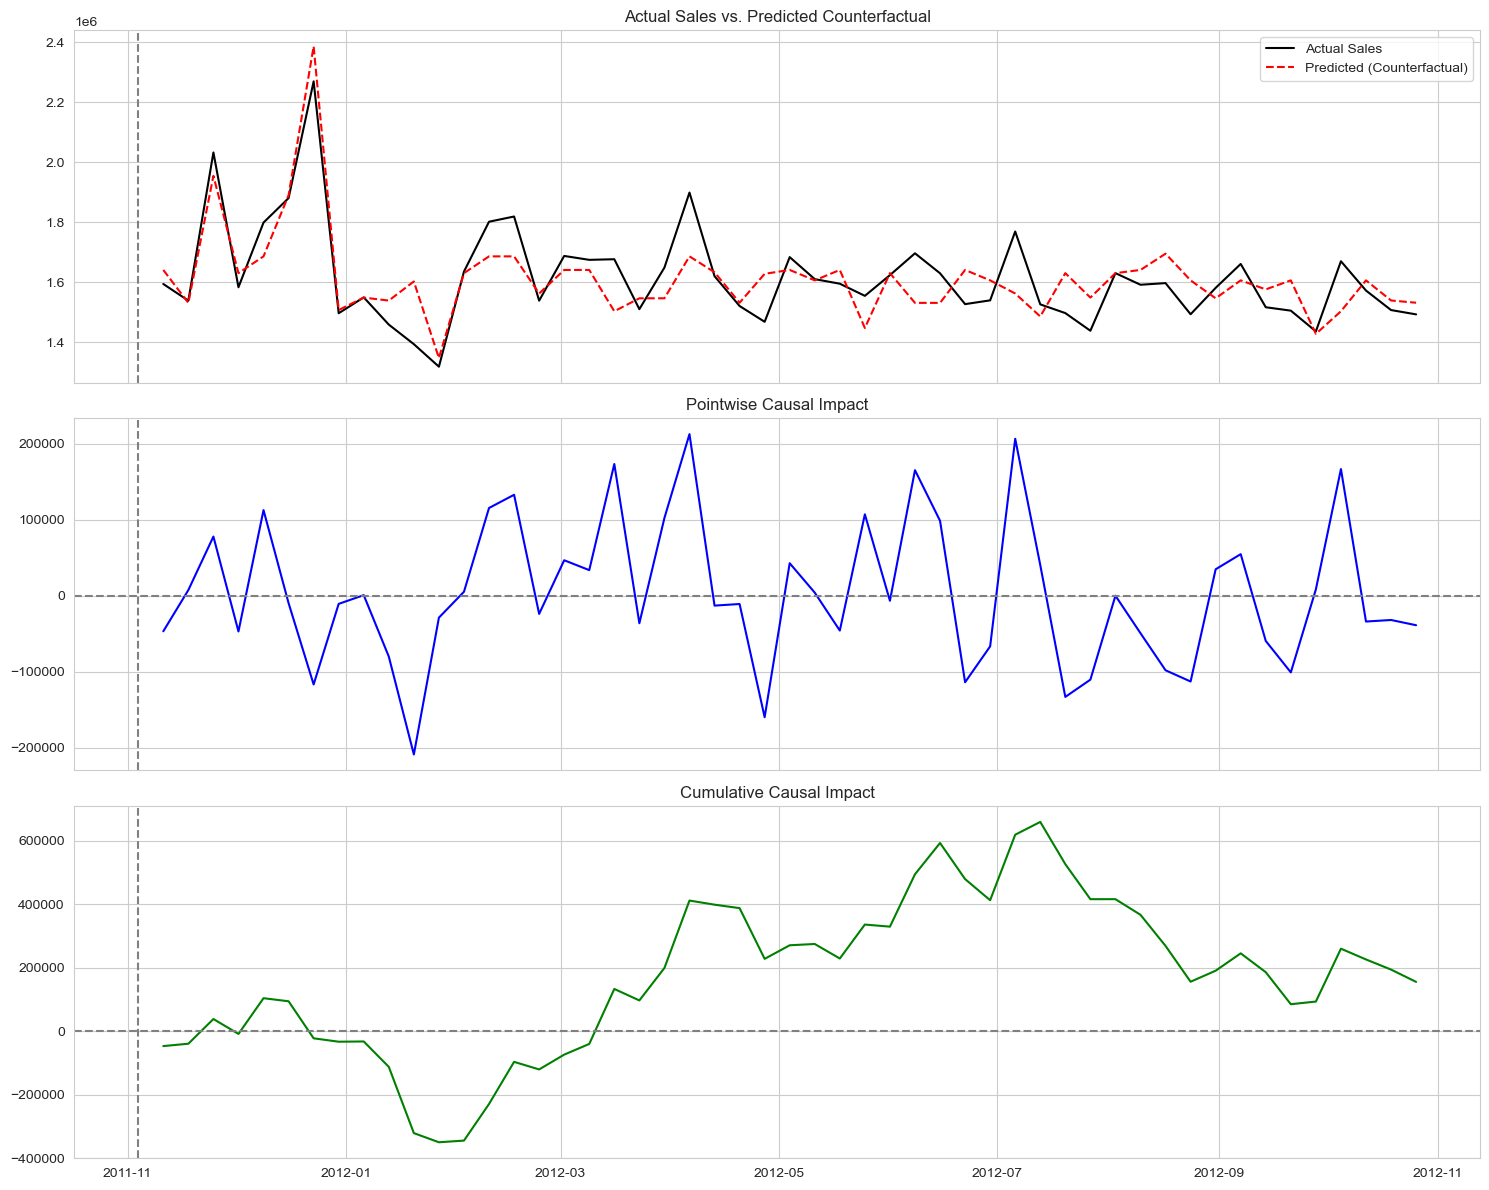

In [ ]:
# --- Causal Impact Analysis with XGBoost ---
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# We use the 'causal_df', 'pre_period', and 'post_period' from the previous step

# Creating training and testing sets based on the promotion date
pre_df = causal_df.loc[pre_period[0]:pre_period[1]]
post_df = causal_df.loc[post_period[0]:post_period[1]]

# The features (X) are the control store sales. The target (y) is the treated store's sales.
X_train = pre_df[Control_Stores]
y_train = pre_df[Treated_Store]

X_test = post_df[Control_Stores]
y_test_actual = post_df[Treated_Store]

# Training an XGBoost model on the pre-promotion data
print("--- Training XGBoost model on pre-promotion period ---")
xgb_causal_model = xgb.XGBRegressor(random_state=42)
xgb_causal_model.fit(X_train, y_train)

# Predicting the "counterfactual" (what sales would have been without the promotion)
print("--- Predicting the counterfactual scenario ---")
counterfactual = xgb_causal_model.predict(X_test)

# Calculating and visualize the impact
results = pd.DataFrame({
    'actual_sales': y_test_actual,
    'predicted_sales (counterfactual)': counterfactual
})
results['impact'] = results['actual_sales'] - results['predicted_sales (counterfactual)']
results['cumulative_impact'] = results['impact'].cumsum()

# Calculating the total impact
total_impact = results['impact'].sum()
relative_impact = (total_impact / results['actual_sales'].sum()) * 100

print("\n--- Causal Impact Analysis Results ---")
print(f"Total Causal Impact: ${total_impact:,.2f} in additional sales.")
print(f"Relative Causal Impact: {relative_impact:.2f}% uplift.")


# Ploting the results
fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
# Panel 1: Original Series and Counterfactual
axs[0].plot(results.index, results['actual_sales'], 'k-', label='Actual Sales')
axs[0].plot(results.index, results['predicted_sales (counterfactual)'], 'r--', label='Predicted (Counterfactual)')
axs[0].axvline(pd.to_datetime(pre_period[1]), color='gray', linestyle='--')
axs[0].set_title('Actual Sales vs. Predicted Counterfactual')
axs[0].legend()

# Panel 2: Pointwise Impact
axs[1].plot(results.index, results['impact'], 'b-')
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].axvline(pd.to_datetime(pre_period[1]), color='gray', linestyle='--')
axs[1].set_title('Pointwise Causal Impact')

# Panel 3: Cumulative Impact
axs[2].plot(results.index, results['cumulative_impact'], 'g-')
axs[2].axhline(y=0, color='gray', linestyle='--')
axs[2].axvline(pd.to_datetime(pre_period[1]), color='gray', linestyle='--')
axs[2].set_title('Cumulative Causal Impact')

plt.tight_layout()
plt.show()

In [ ]:
# --- Reusable Causal Impact Function ---
import pandas as pd
import numpy as np
import xgboost as xgb

def analyze_impact(data_df, treated_store, control_stores, promotion_start_date, markdown_type):
   
    print(f"\n--- Analyzing Impact of {markdown_type} on Store {treated_store} ---")
    
    # Prepare data
    pre_period_end_date = (pd.to_datetime(promotion_start_date) - pd.DateOffset(weeks=1)).strftime('%Y-%m-%d')
    causal_df = data_df.groupby(['Date', 'Store'])['Weekly_Sales'].sum().unstack()
    causal_df = causal_df[[treated_store] + control_stores]
    causal_df.dropna(inplace=True)

    pre_period = [str(causal_df.index.min().date()), pre_period_end_date]
    post_period = [promotion_start_date, str(causal_df.index.max().date())]
    
    pre_df = causal_df.loc[pre_period[0]:pre_period[1]]
    post_df = causal_df.loc[post_period[0]:post_period[1]]
    
    # Checking if there is data in the post-period to analyze
    if post_df.empty:
        print(f"No data available for the post-promotion period. Skipping analysis.")
        return None, None

    X_train = pre_df[control_stores]
    y_train = pre_df[treated_store]
    X_test = post_df[control_stores]
    y_test_actual = post_df[treated_store]
    
    # Training model and predicting counterfactual
    model = xgb.XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    counterfactual = model.predict(X_test)
    
    # 3. Calculating impact
    total_impact = y_test_actual.sum() - counterfactual.sum()
    relative_impact = (total_impact / y_test_actual.sum()) * 100
    
    print(f"Total Causal Impact: ${total_impact:,.2f} in additional sales.")
    print(f"Relative Causal Impact: {relative_impact:.2f}% uplift.")
    
    return total_impact, relative_impact


# Scenario 1: The MarkDown1 event we already analyzed
analyze_impact(
    data_df=master_df,
    treated_store=1,
    control_stores=[4],
    promotion_start_date='2011-11-11',
    markdown_type='MarkDown1'
)

# Scenario 2: Let's find and analyze a MarkDown2 event for Store 2
analyze_impact(
    data_df=master_df,
    treated_store=2,
    control_stores=[6, 8], # Other large Type A stores
    promotion_start_date='2011-07-22',
    markdown_type='MarkDown2'
)


--- Analyzing Impact of MarkDown1 on Store 1 ---
Total Causal Impact: $155,659.98 in additional sales.
Relative Causal Impact: 0.19% uplift.

--- Analyzing Impact of MarkDown2 on Store 2 ---
Total Causal Impact: $-2,240,085.92 in additional sales.
Relative Causal Impact: -1.75% uplift.


(-2240085.9200000167, -1.7472849820938934)